In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
# from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns
import numpy.typing as npt

In [2]:
number = 3

# File name to process
directory = './12_19_2023/run{}/'.format(number)
file_name = directory + 'samples_{}.h5'.format(number, number)
save_name = directory + 'samples{}.npy'.format(number, number)
n_burn = 50000

In [3]:
# Load in the samples
reader = emcee.backends.HDFBackend(file_name)
samples_not_flat = reader.get_chain()
samples_flat = reader.get_chain(flat = True)

In [4]:
loader = DataLoader(0.676, 2.624, 'som')
data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']
# Add normalization labels
for i in range(0, int(np.max(norm_group) + 1)):
    labels.append('f_{}'.format(i))

def generate_trace_plot(samples_not_flat):
    # Generate the trace plot given a set of samples
    fig, axes = plt.subplots(samples_not_flat.shape[2], figsize = (20, 40))
    for i in range(0, samples_not_flat.shape[2]):
        ax = axes[i]
        for j in range(0, samples_not_flat.shape[1]):
            ax.plot(samples_not_flat[:, :, i][:, j])
            ax.set_ylabel(labels[i])
    axes[-1].set_xlabel('Step Number')
    plt.show()

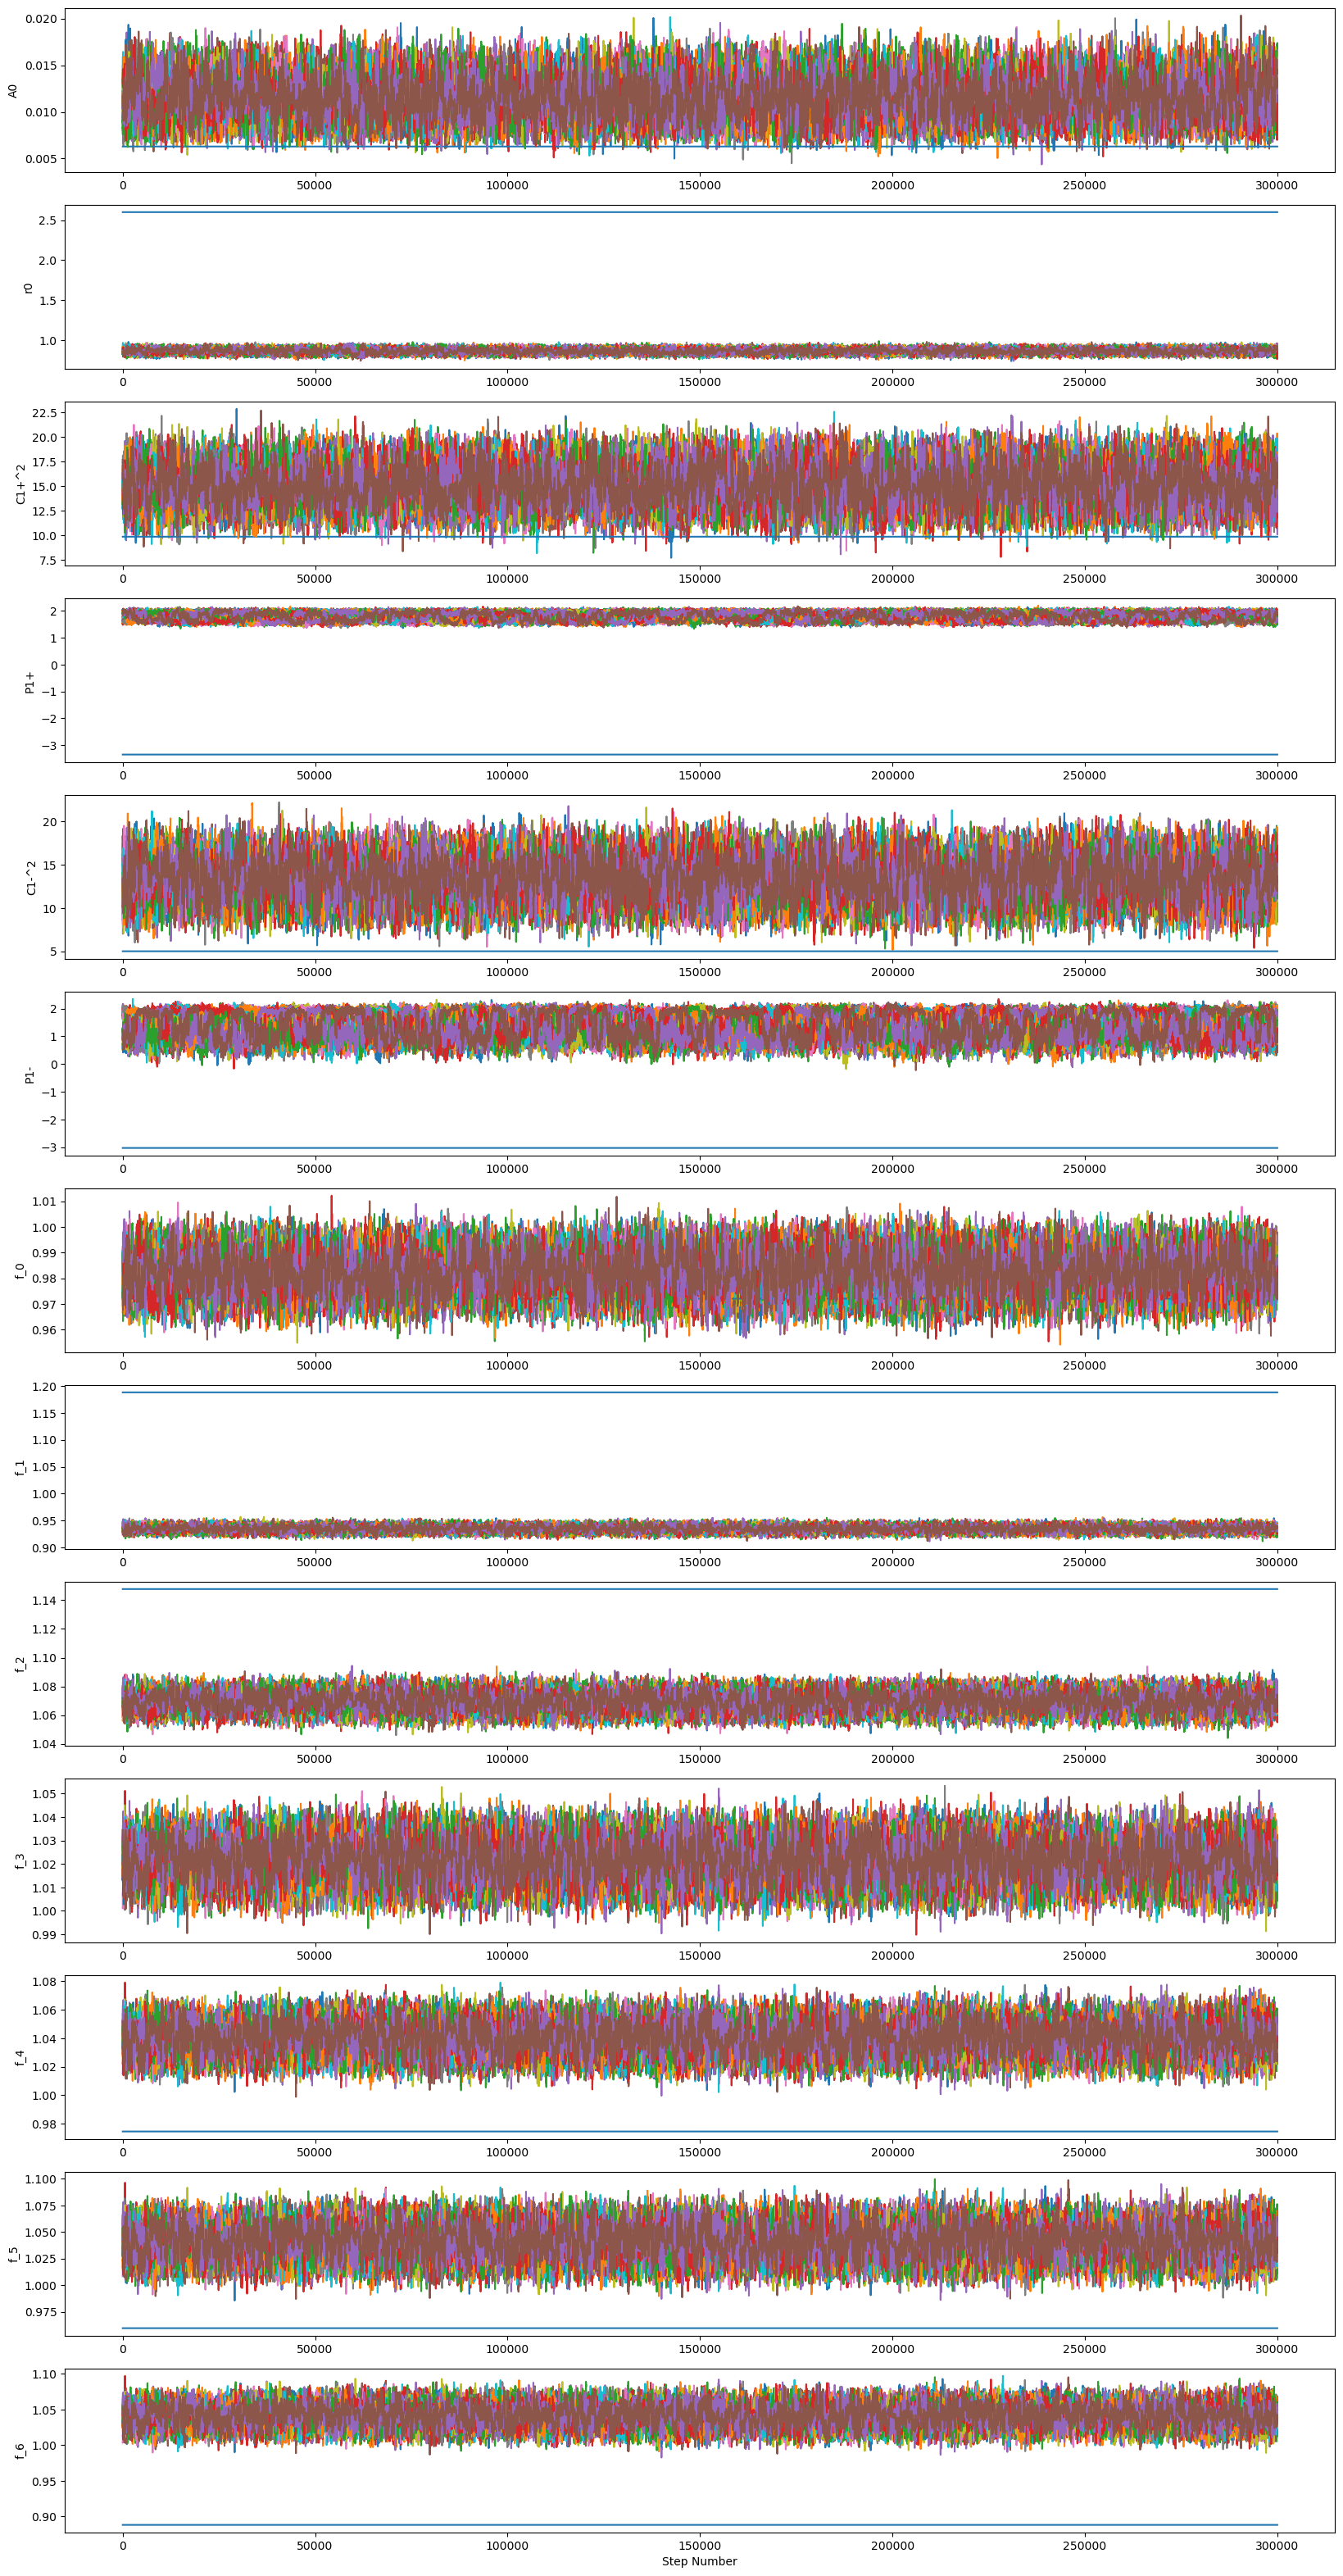

In [5]:
generate_trace_plot(samples_not_flat[n_burn:, :, :])

In [6]:
# Look at the variances within each chain to determine if the walker is moving enough or if it is stuck.
within_chain_means = np.mean(samples_not_flat[n_burn:, :, :], axis = 0)

# Create an empty array of the within chain variances
within_chain_var = np.empty(within_chain_means.shape)

# Run a for loop across all walkers to compute the within chain variance
for i in range(0, within_chain_means.shape[0]):
    within_chain_var[i, :] = np.sum(np.square(within_chain_means[i, :] - samples_not_flat[n_burn:, i, :]), axis = 0) / (samples_not_flat.shape[0] // 2)

# Get the typical within chain variance W for each parameter
W = np.median(within_chain_var, axis = 0)


# Now we need to loop over each chain for each parameter to see how it compares to the typical variance
bad_indices = []
ratios = np.empty(within_chain_means.shape)
# Loop over each parameter
for i in range(0, within_chain_means.shape[1]):
    # Loop over the walkers
    for j in range(0, within_chain_means.shape[0]):
        ratio = np.sum(within_chain_var[j, i] / W[i]) / within_chain_means.shape[1]
        ratios[j, i] = ratio

# Sum along each parameter, this value should be very close to 1.0. Select out the bad indices
total_normalized_ratios = np.sum(ratios, axis = 1)
bad_indices = np.where(total_normalized_ratios <= 0.9)[0]
print('Found {} bad walkers at indices:'.format(bad_indices.shape[0]))
print(bad_indices)

if bad_indices.shape[0] != 0:
    # Remove the bad walkers
    samples_not_flat = np.delete(samples_not_flat, bad_indices, axis = 1)

Found 1 bad walkers at indices:
[20]


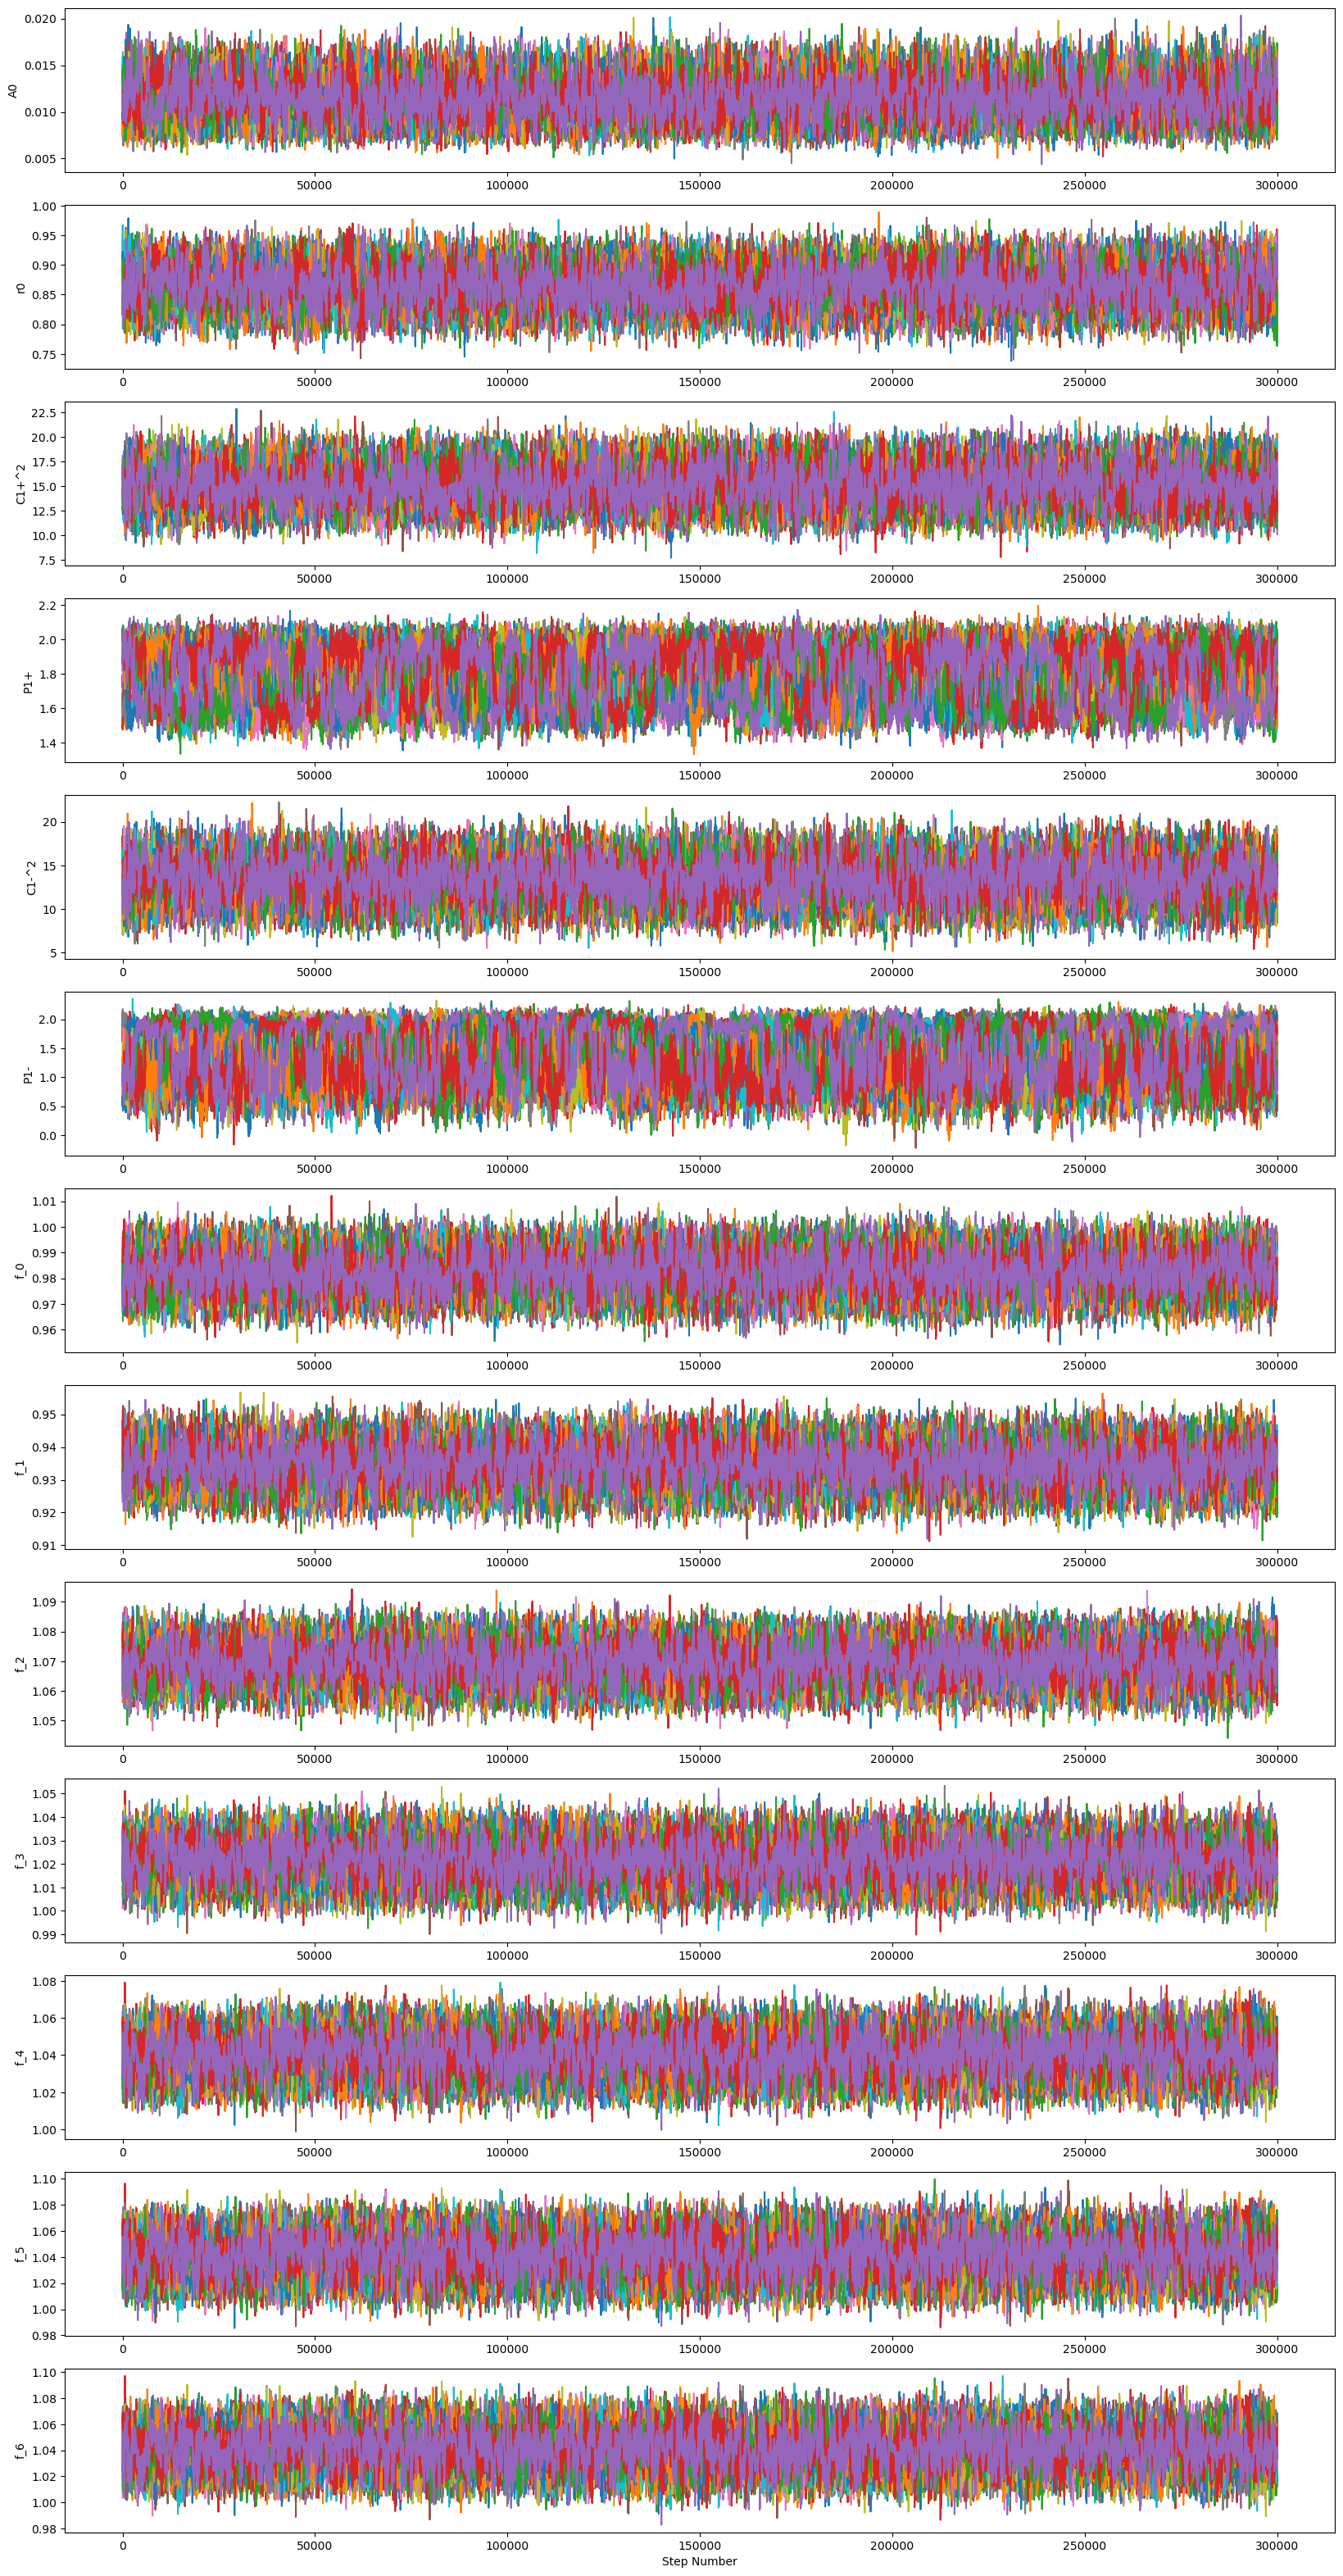

In [7]:
generate_trace_plot(samples_not_flat[n_burn:, :, :])

In [8]:
# Thin according to the burn-in time
thinned_samples_not_flat = samples_not_flat[n_burn:, :, :]

# Compute the autocorrelation times for each parameter
ac_s = reader.get_autocorr_time(discard = n_burn, tol = 0)
ac = int(np.max(ac_s))

print(ac_s)
print('Autocorrelation time: {}'.format(ac))

# Thin according to the autocorrelation time
thinned_samples_not_flat = thinned_samples_not_flat[::ac, :, :]

# Flatten the samples and log-prob
len0, len1, len2 = thinned_samples_not_flat.shape
samples = np.reshape(thinned_samples_not_flat, (len0 * len1, len2))

[ 677.9126597   693.73205772  793.98590145 3160.34124829  789.32849619
 2953.14940397  726.31822025  678.87083899  707.73425578  744.97781445
  713.36310882  685.68856005  695.92473125]
Autocorrelation time: 3160


In [9]:
# generate_trace_plot(thinned_samples_not_flat)

In [22]:
np.save(save_name, thinned_samples_not_flat)
print(thinned_samples_not_flat.shape)

(95, 25, 13)


In [11]:
# # def get_ac(single_chain: npt.ArrayLike, tau_max: int = None) -> int:
# #     N = single_chain.shape[0]
# #     if tau_max is None:
# #         tau_max = N // 10

# def ac_function1(single_chain: npt.ArrayLike, tau: int) -> float:
#     mean = np.mean(single_chain)
#     N = single_chain.shape[0]
#     c = 0
#     for n in range(0, int(N - tau)):
#         c += (single_chain[n] - mean) * (single_chain[n + tau] - mean)
#     c *= 1 / (N - tau)
#     return c

# def ac_function2(single_chain: npt.ArrayLike, tau: int, norm: bool = True) -> float:
#     mean = np.mean(single_chain)
#     N = single_chain.shape[0]
#     c = np.sum((single_chain[:int(N - tau)] - mean) * (single_chain[tau:] - mean)) / (N - tau)
#     if norm:
#         c /= np.sum(np.square(single_chain[:] - mean)) / N
#     return c
    

In [12]:
# ac_function2(samples_not_flat[50000:, 0, 0], 0)

In [13]:
# chain_number = 0
# param_number = 3

# taus = np.arange(0, samples_not_flat.shape[0]//100)
# acs = [ac_function2(samples_not_flat[50000:, chain_number, param_number], tau) for tau in taus]
# plt.plot(taus, acs)
# plt.plot(int(ac_s[param_number]), acs[int(ac_s[param_number])], 'o')

In [14]:
# ac_s

In [15]:
# param_number = 3
# all_acs = []
# for chain_number in range(0, samples_not_flat.shape[1]):
#     taus = np.arange(0, samples_not_flat.shape[0]//100)
#     acs = [ac_function2(samples_not_flat[50000:, chain_number, param_number], tau) for tau in taus]
#     all_acs.append(acs)
#     plt.plot(taus, acs, alpha = 0.2)
# plt.plot(int(ac_s[param_number]), acs[int(ac_s[param_number])], 'o')

In [16]:
# for i in range(0, 26):
#     plt.plot(taus, all_acs[i], alpha = 0.2)
#     plt.plot(int(ac_s[param_number]), all_acs[i][int(ac_s[param_number])], 'o', alpha = 0.3)
# # plt.plot(taus, np.median(all_acs, axis = 0), 'k')
# plt.plot(taus, np.mean(all_acs, axis = 0), 'k')
# plt.yscale('log')
# plt.xlim(0, 700)
# plt.show()

In [17]:
# to_average = []
# for i in range(0, 26):
#     real_tau = []
#     for M in range(0, samples_not_flat.shape[0]//100):
#         real_tau.append(1 + 2 * np.sum(all_acs[i][:M]))
#     real_tau = np.array(real_tau)
#     # to_average.append(real_tau[1912])
#     to_average.append(real_tau[2400])
#     mod = 5 * real_tau
#     plt.plot(range(0, samples_not_flat.shape[0]//100), mod, alpha = 0.2)
# plt.plot(np.linspace(0, 2500, 10), np.linspace(0, 2500, 10))
# lim = (1000, 3000)
# # plt.xlim(lim)
# # plt.ylim(lim)

In [18]:
# np.mean(to_average)

In [19]:
# # -*- coding: utf-8 -*-
# def next_pow_two(n):
#     """Returns the next power of two greater than or equal to `n`"""
#     i = 1
#     while i < n:
#         i = i << 1
#     return i


# def function_1d(x):
#     """Estimate the normalized autocorrelation function of a 1-D series

#     Args:
#         x: The series as a 1-D numpy array.

#     Returns:
#         array: The autocorrelation function of the time series.

#     """
#     x = np.atleast_1d(x)
#     if len(x.shape) != 1:
#         raise ValueError("invalid dimensions for 1D autocorrelation function")
#     n = next_pow_two(len(x))

#     # Compute the FFT and then (from that) the auto-correlation function
#     f = np.fft.fft(x - np.mean(x), n=2 * n)
#     acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
#     acf /= acf[0]
#     return acf


# def auto_window(taus, c):
#     m = np.arange(len(taus)) < c * taus
#     if np.any(m):
#         return np.argmin(m)
#     return len(taus) - 1


# def integrated_time(x, c=5, tol=50, quiet=False):
#     """Estimate the integrated autocorrelation time of a time series.

#     This estimate uses the iterative procedure described on page 16 of
#     `Sokal's notes <https://www.semanticscholar.org/paper/Monte-Carlo-Methods-in-Statistical-Mechanics%3A-and-Sokal/0bfe9e3db30605fe2d4d26e1a288a5e2997e7225>`_ to
#     determine a reasonable window size.

#     Args:
#         x: The time series. If multidimensional, set the time axis using the
#             ``axis`` keyword argument and the function will be computed for
#             every other axis.
#         c (Optional[float]): The step size for the window search. (default:
#             ``5``)
#         tol (Optional[float]): The minimum number of autocorrelation times
#             needed to trust the estimate. (default: ``50``)
#         quiet (Optional[bool]): This argument controls the behavior when the
#             chain is too short. If ``True``, give a warning instead of raising
#             an :class:`AutocorrError`. (default: ``False``)

#     Returns:
#         float or array: An estimate of the integrated autocorrelation time of
#             the time series ``x`` computed along the axis ``axis``.

#     Raises
#         AutocorrError: If the autocorrelation time can't be reliably estimated
#             from the chain and ``quiet`` is ``False``. This normally means
#             that the chain is too short.

#     """
#     x = np.atleast_1d(x)
#     if len(x.shape) == 1:
#         x = x[:, np.newaxis, np.newaxis]
#     if len(x.shape) == 2:
#         x = x[:, :, np.newaxis]
#     if len(x.shape) != 3:
#         raise ValueError("invalid dimensions")

#     n_t, n_w, n_d = x.shape
#     tau_est = np.empty(n_d)
#     windows = np.empty(n_d, dtype=int)

#     # Loop over parameters
#     for d in range(n_d):
#         f = np.zeros(n_t)
#         for k in range(n_w):
#             f += function_1d(x[:, k, d])
#         f /= n_w
#         taus = 2.0 * np.cumsum(f) - 1.0
#         windows[d] = auto_window(taus, c)
#         tau_est[d] = taus[windows[d]]

#     # Check convergence
#     flag = tol * tau_est > n_t

#     # Warn or raise in the case of non-convergence
#     if np.any(flag):
#         msg = (
#             "The chain is shorter than {0} times the integrated "
#             "autocorrelation time for {1} parameter(s). Use this estimate "
#             "with caution and run a longer chain!\n"
#         ).format(tol, np.sum(flag))
#         msg += "N/{0} = {1:.0f};\ntau: {2}".format(tol, n_t / tol, tau_est)
#         if not quiet:
#             raise AutocorrError(tau_est, msg)
#         # logger.warning(msg)

#     return tau_est


# class AutocorrError(Exception):
#     """Raised if the chain is too short to estimate an autocorrelation time.

#     The current estimate of the autocorrelation time can be accessed via the
#     ``tau`` attribute of this exception.

#     """

#     def __init__(self, tau, *args, **kwargs):
#         self.tau = tau
#         super(AutocorrError, self).__init__(*args, **kwargs)


In [20]:
# integrated_time(samples_not_flat[n_burn:, :, :])

In [21]:
# ac_s